In [ ]:
#|hide
import math
import torch
import torch.nn as nn, torch.nn.functional as F, torch.optim as optim
from fastai.vision.all import *
from FastFF.models.fff import FFF
from FastFF.activations import *
from FastFF.performance import *
import wandb
from fastai.callback.wandb import *

In [ ]:
#|hide
#|eval: false
h = 32
d = 4
bs = 512


model_fff = FFF(28*28, 2, d, hidden_dim=h)
model = nn.Sequential(model_fff, nn.ReLU(), nn.Linear(2,10))
cbs = [ProbsDistrCB(module=model_fff)]
learn = Learner(get_mnist_dls(bs), model, F.cross_entropy, metrics=accuracy, cbs=cbs)
learn.fit_one_cycle(10, lr_max=2e-2)

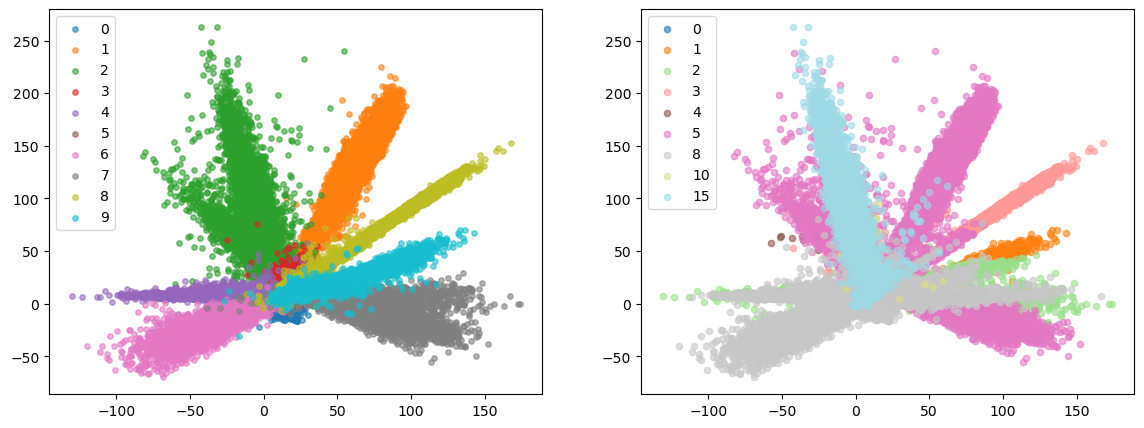

In [ ]:
#|eval: false
acts = [Activations2D(model_fff), LeavesColors(model_fff, model_fff)]
with learn.removed_cbs(cbs): learn.get_preds(0, cbs=acts);
axes = subplots(ncols=2,figsize=(14,5))[1]
acts[0].show_acts(ax=axes[0], cmap='tab10',s=15)
acts[1].show_acts(lambda x: x.argmax(1), ax=axes[1], cmap='tab20',s=20)

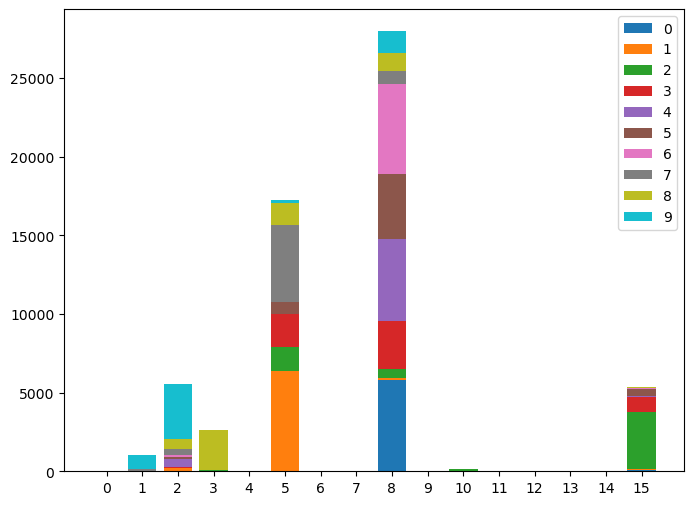

In [ ]:
#|eval: false
cbs[0].show(-1)

## Sweep

In [ ]:
sweep_cfg = {
    'method': 'grid',
    'metric':{'name': 'valid_loss','goal':'minimize'},
    'parameters':{
        'bs': {'value': 256},
        'learn':{'parameters':{'lr_max': {'value':7e-3}}},
        'model':{'parameters':{
            'h_2d': {'value': 16},
            'd': {'value': 4},
            'act': {'value': 'relu'},
            'region_leak': {'values':[0, 0.05, 0.1, 0.15, 0.2, 0.25, 0.3, 0.35, 0.4, 0.45, 0.5]},
            }},
        'epochs': {'value': 10}
    }
}

def run(cfg):
    model_fff = FFF(28*28, 2,  cfg.model['d'], hidden_dim=cfg.model['h_2d'], leak=cfg.model['region_leak'])
    model = nn.Sequential(model_fff, nn.ReLU(), nn.Linear(2,10))
    cbs = [WandbCallback(log_preds=False), ProbsDistrCB(wandb = True, module=model_fff, sample_size=100)]
    learn = Learner(get_mnist_dls(cfg.bs), model, F.cross_entropy, metrics=accuracy, cbs=cbs)
    learn.fit_one_cycle(cfg.epochs, lr_max=cfg.learn['lr_max'])
    
    acts = [Activations2D(model_fff), LeavesColors(model_fff, model_fff)]
    with learn.removed_cbs(cbs): learn.get_preds(0, cbs=acts);
    fig, axes = subplots(ncols=2,figsize=(15,5))
    acts[0].show_acts(ax=axes[0], cmap='tab10',s=15)
    acts[1].show_acts(lambda x: x.argmax(1), ax=axes[1], cmap='tab20',s=20)
    wandb.log({'2D activations':fig})

In [ ]:
#|eval: false
runs_sweep(sweep_cfg, 'FFF', 20, sweep_name="Region leaks 2d")(run)